In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testdd/test.csv
/kaggle/input/traind/train.csv



**libraries**

In [2]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.7 MB/s eta 0:00:0000:0100:01


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import csv
import re
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords' , quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
import time
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)


lematizer = WordNetLemmatizer()
spelling = SpellChecker()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Data read**

In [4]:
# H2O
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [5]:
file_path = '/kaggle/input/traind/train.csv'
df_train = pd.read_csv(file_path)
df_train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


In [6]:
file_path_ = '/kaggle/input/testdd/test.csv'
df_test = pd.read_csv(file_path_)
df_test

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


**Data cleaning**

In [7]:
def clean_text(text):
    # Remove special characters, punctuation marks (except apostrophes), and non-alphanumeric characters
    cleaned_text = re.sub(r"[^a-zA-Z0-9'.,; ]", "", text)
    
    # Retain certain punctuation marks for coherence and structure
    preserved_punctuation = ['.', ',', ';']
    cleaned_text = ''.join([char for char in cleaned_text if char in preserved_punctuation or char.isalnum() or char == ' '])
    
    return cleaned_text


In [8]:
def preprocess(comment):
    comment = re.sub(r'[^A-Za-z\s]', '', comment)

    cspellwords = [spelling.correction(word) if spelling.correction(word) is not None else word for word in comment.split()]
    token = word_tokenize(' '.join(cspellwords))

    stop_words = set(stopwords.words('english'))
    normalized_words = [word.lower() for word in token if word.lower() not in stop_words]

    lemmatized_words = []
    for word, tag in nltk.pos_tag(normalized_words):
        pos = tag[0].lower()  # Convert POS tag to WordNet format
        pos = pos if pos in ['a', 'r', 'n', 'v'] else 'n' 

        lemma = lematizer.lemmatize(word, pos=pos)
        lemmatized_words.append(lemma)

    print(lemmatized_words)
    return ' '.join(lemmatized_words)

In [9]:
# Apply text cleaning to the 'full_text' column in df_train
df_train['full_text'] = df_train['full_text'].apply(clean_text)

# Apply text cleaning to the 'full_text' column in df_test
df_test['full_text'] = df_test['full_text'].apply(clean_text)

In [10]:
# remove redundant spaces
df_train.full_text = df_train.full_text.str.strip()
df_test.full_text = df_test.full_text.str.strip()

**Visualizations**

In [11]:
# format target as integer
df_train.score = df_train.score.astype(int)

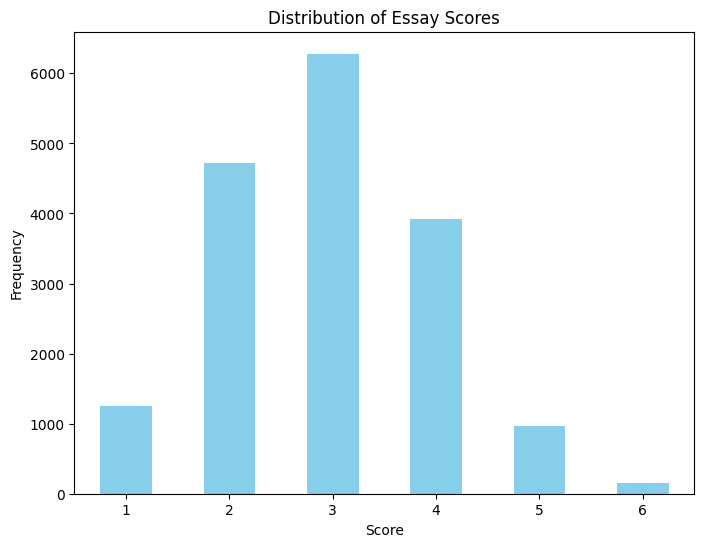

In [12]:
# Visualize the distribution of essay scores 
plt.figure(figsize=(8, 6))
df_train['score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

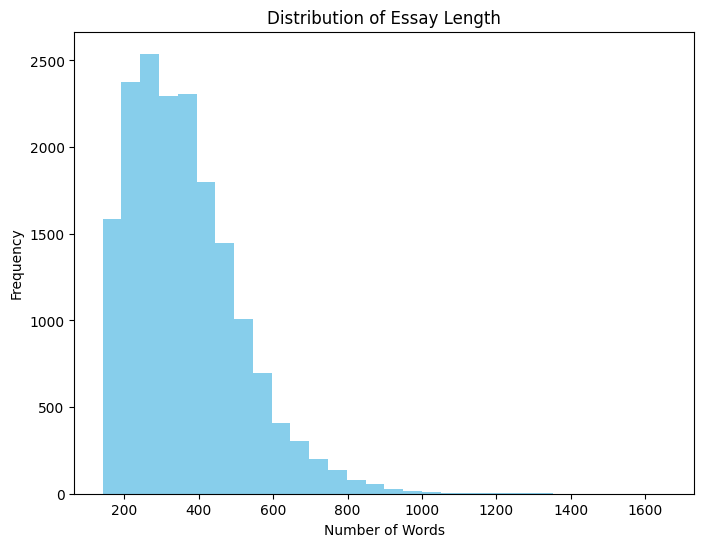

In [13]:
# Explore the length distribution of essays (number of words)
df_train['word_count'] = df_train['full_text'].apply(lambda x: len(x.split()))  # Split text into words
plt.figure(figsize=(8, 6))
plt.hist(df_train['word_count'], bins=30, color='skyblue')
plt.title('Distribution of Essay Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

**Feature engineering**

In [14]:
# Word Count
df_train['word_count'] = df_train['full_text'].apply(lambda x: len(x.split()))

# Character Count
df_train['char_count'] = df_train['full_text'].apply(len)

# Average Word Length
df_train['avg_word_length'] = df_train.apply(lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)

# Sentence Count
df_train['sentence_count'] = df_train['full_text'].apply(lambda x: len(sent_tokenize(x)))

# Average Sentence Length
df_train['avg_sentence_length'] = df_train.apply(lambda row: row['word_count'] / row['sentence_count'] if row['sentence_count'] > 0 else 0, axis=1)

# Readability Scores (Using TextBlob's sentiment analysis)
from textblob import TextBlob
df_train['readability'] = df_train['full_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)  # Example: Using subjectivity score as a proxy for readability

In [15]:
# Word Count
df_test['word_count'] = df_test['full_text'].apply(lambda x: len(x.split()))

# Character Count
df_test['char_count'] = df_test['full_text'].apply(len)

# Average Word Length
df_test['avg_word_length'] = df_test.apply(lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)

# Sentence Count
df_test['sentence_count'] = df_test['full_text'].apply(lambda x: len(sent_tokenize(x)))

# Average Sentence Length
df_test['avg_sentence_length'] = df_test.apply(lambda row: row['word_count'] / row['sentence_count'] if row['sentence_count'] > 0 else 0, axis=1)

# Readability Scores (Using TextBlob's sentiment analysis)
df_test['readability'] = df_test['full_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [16]:
print(df_train.head())

  essay_id                                          full_text  score  \
0  000d118  Many people have car where they live. The thin...      3   
1  000fe60  I am a scientist at NASA that is discussing th...      3   
2  001ab80  People always wish they had the same technolog...      4   
3  001bdc0  We all heard about Venus, the planet without a...      4   
4  002ba53  Dear, State SenatorThis is a letter to argue i...      3   

   word_count  char_count  avg_word_length  sentence_count  \
0         493        2654         5.383367              13   
1         328        1645         5.015244              14   
2         547        3046         5.568556              21   
3         445        2671         6.002247              16   
4         368        2167         5.888587              10   

   avg_sentence_length  readability  
0            37.923077     0.542236  
1            23.428571     0.490972  
2            26.047619     0.459479  
3            27.812500     0.540318  
4   

In [17]:
new_features = ['word_count', 'char_count', 'avg_word_length', 'sentence_count', 'avg_sentence_length', 'readability']
df_train[new_features].describe()

,word_count,char_count,avg_word_length,sentence_count,avg_sentence_length,readability
count,17307.000000,17307.000000,17307.000000,17307.000000,17307.000000,17307.000000
mean,364.042179,2030.517132,5.560348,14.614722,34.512278,0.492092
std,149.334472,858.007263,0.311901,7.548284,47.187444,0.085483
min,142.000000,709.000000,4.494845,1.000000,8.619048,0.000000
25%,250.000000,1375.000000,5.343558,9.000000,20.318182,0.436152
50%,340.000000,1892.000000,5.558219,14.000000,24.523810,0.490414
75%,447.000000,2502.000000,5.774918,19.000000,30.937500,0.546364
max,1656.000000,8015.000000,6.891791,69.000000,777.000000,0.913889


In [18]:
df_train

,essay_id,full_text,score,word_count,char_count,avg_word_length,sentence_count,avg_sentence_length,readability
0,000d118,Many people have car where they live. The thin...,3,493,2654,5.383367,13,37.923077,0.542236
1,000fe60,I am a scientist at NASA that is discussing th...,3,328,1645,5.015244,14,23.428571,0.490972
2,001ab80,People always wish they had the same technolog...,4,547,3046,5.568556,21,26.047619,0.459479
3,001bdc0,"We all heard about Venus, the planet without a...",4,445,2671,6.002247,16,27.812500,0.540318
4,002ba53,"Dear, State SenatorThis is a letter to argue i...",3,368,2167,5.888587,10,36.800000,0.586453
...,...,...,...,...,...,...,...,...,...
17302,ffd378d,the story The Challenge of Exploing Venus is...,2,153,850,5.555556,7,21.857143,0.350525
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,574,3319,5.782230,21,27.333333,0.522858
17304,fff016d,If you dont like sitting around all day than i...,2,213,1113,5.225352,13,16.384615,0.481349
17305,fffb49b,"In The Challenge of Exporing Venus, the author...",1,230,1413,6.143478,11,20.909091,0.543756


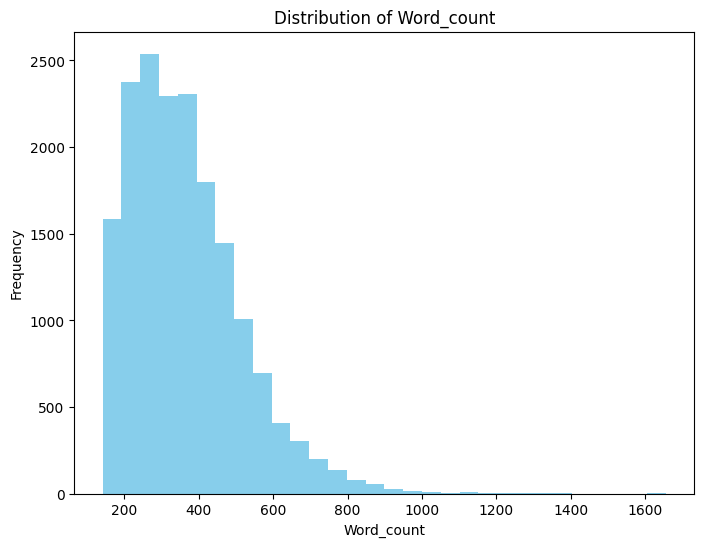

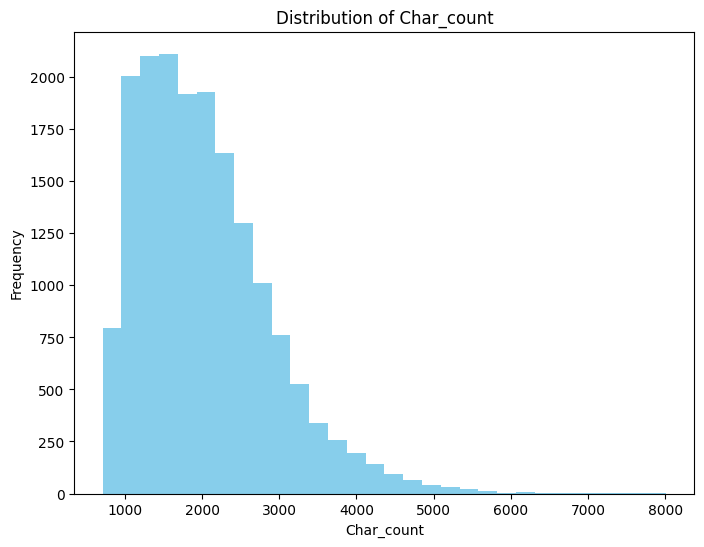

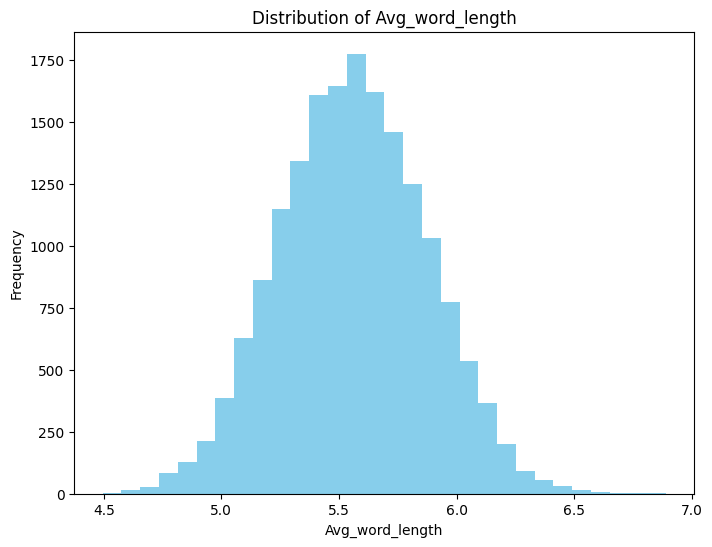

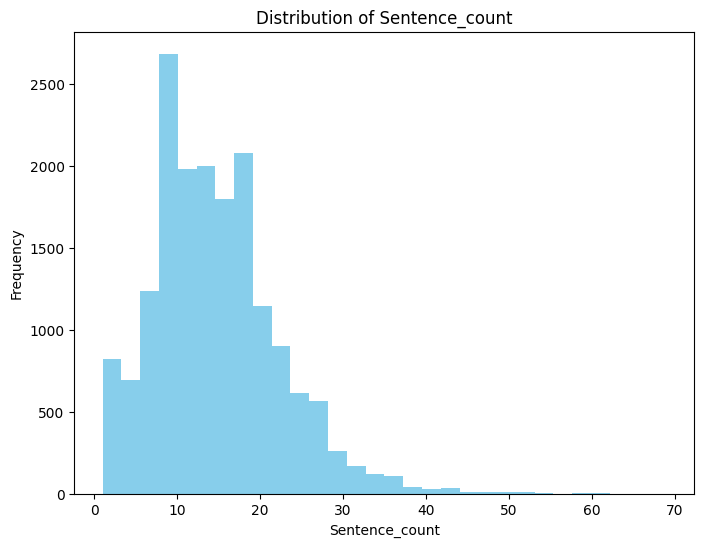

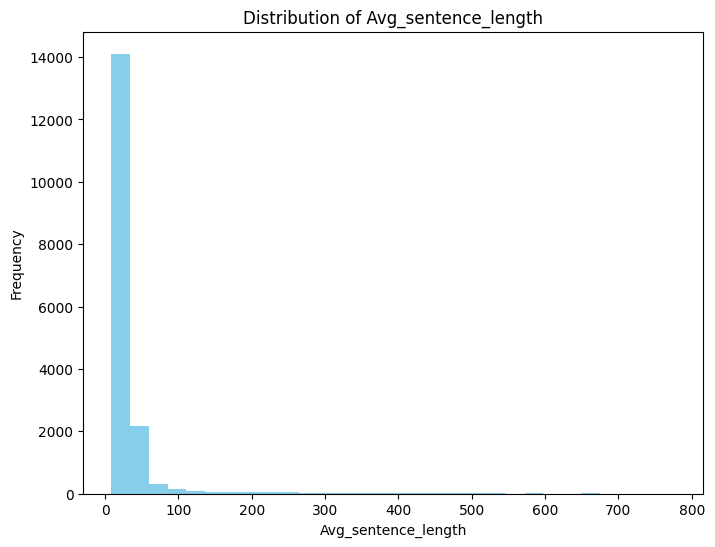

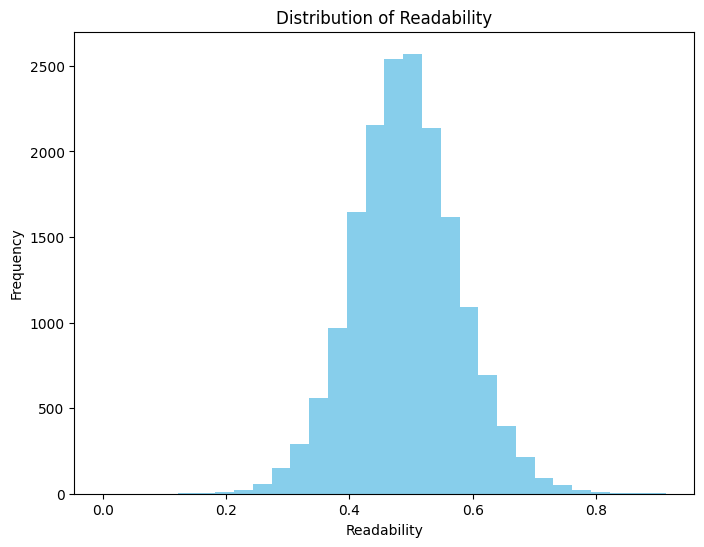

In [19]:
# Plot histograms for each new feature
for feature in new_features:
    plt.figure(figsize=(8, 6))
    plt.hist(df_train[feature], bins=30, color='skyblue')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.show()

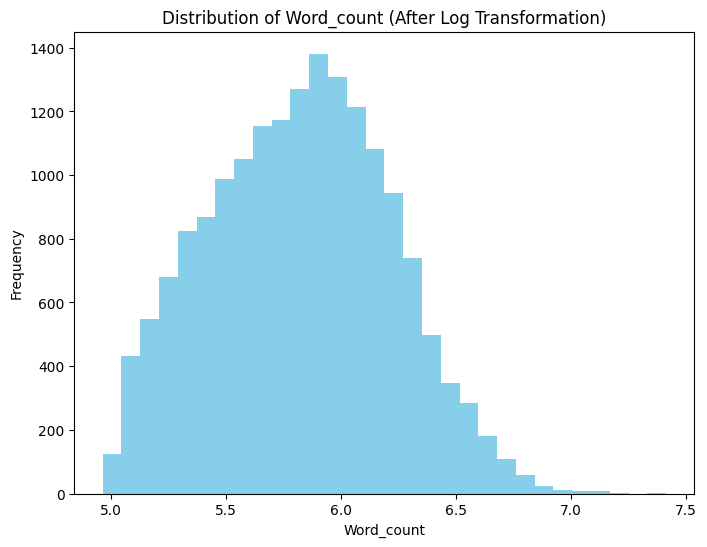

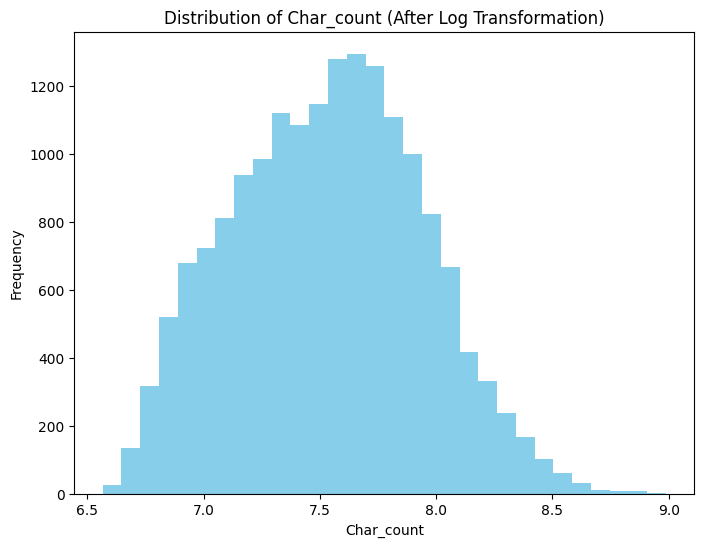

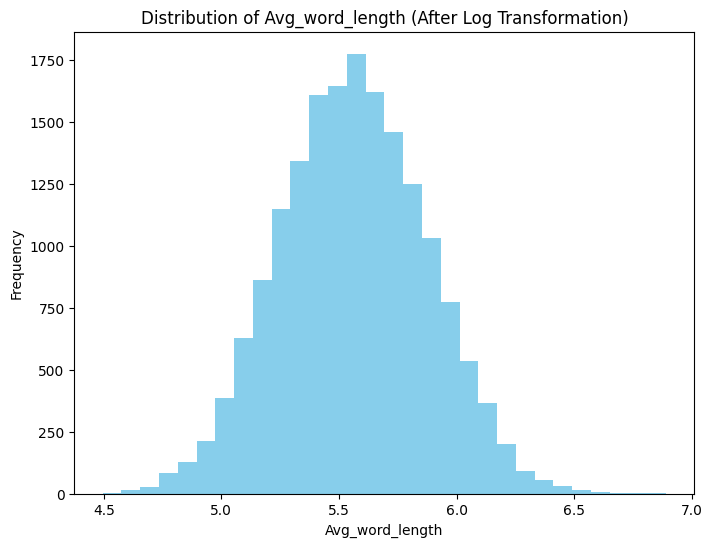

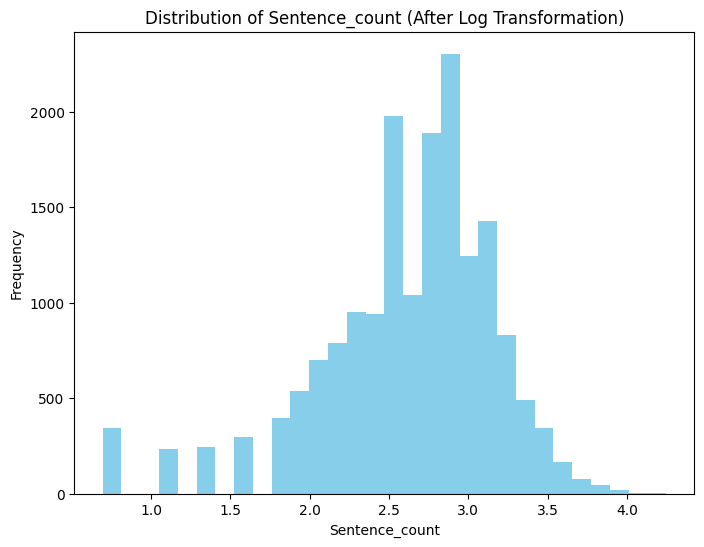

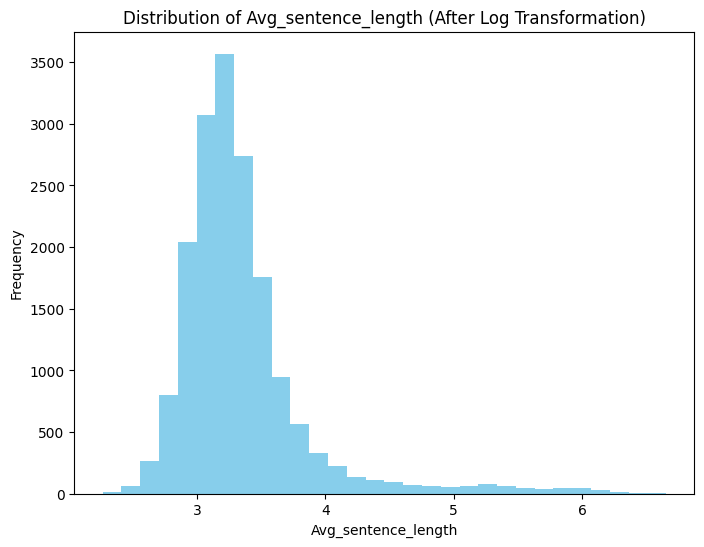

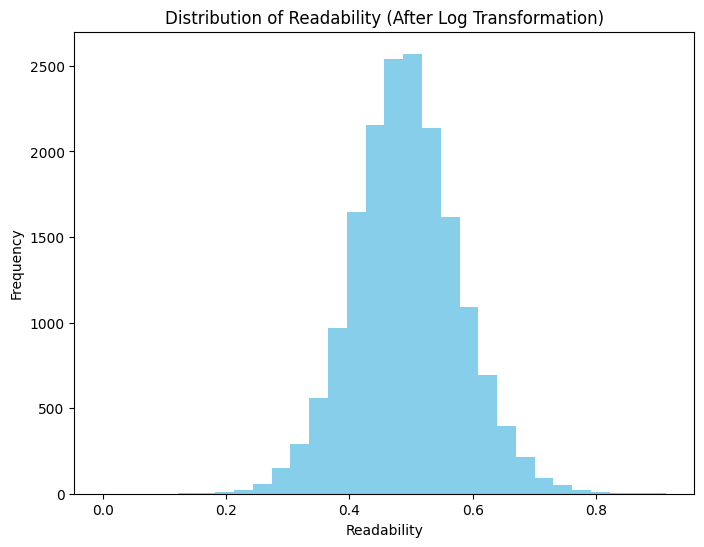

In [20]:
import numpy as np

# Define the skewed features
skewed_features = ['word_count', 'char_count', 'sentence_count', 'avg_sentence_length']

# Apply log transformation to skewed features
for feature in skewed_features:
    df_train[feature] = np.log1p(df_train[feature])  # Using np.log1p to avoid errors with zero values

for feature in skewed_features:
    df_test[feature] = np.log1p(df_test[feature])  # Using np.log1p to avoid errors with zero values
    
# Plot histograms for each new feature after log transformation
for feature in new_features:
    plt.figure(figsize=(8, 6))
    plt.hist(df_train[feature], bins=30, color='skyblue')
    plt.title(f'Distribution of {feature.capitalize()} (After Log Transformation)')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.show()

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Define the features to be scaled
features_to_scale = ['word_count', 'char_count', 'sentence_count', 'avg_sentence_length']

# Fit the scaler to the training data and transform the features
df_train[features_to_scale] = scaler.fit_transform(df_train[features_to_scale])
df_test[features_to_scale] = scaler.fit_transform(df_test[features_to_scale])


# Display the scaled features
print(df_train[features_to_scale].head())

   word_count  char_count  sentence_count  avg_sentence_length
0    0.966202    0.862469        0.045727             0.618110
1   -0.065838   -0.313136        0.167968            -0.286586
2    1.229595    1.201095        0.846550            -0.088791
3    0.706676    0.878163        0.389731             0.033970
4    0.225482    0.364193       -0.381562             0.561249


Correlation Matrix:
                     word_count  char_count  sentence_count  \
word_count             1.000000    0.990601        0.626465   
char_count             0.990601    1.000000        0.618699   
sentence_count         0.626465    0.618699        1.000000   
avg_sentence_length    0.012298    0.014869       -0.767913   
readability           -0.019359   -0.019224       -0.028129   
score                  0.706068    0.717664        0.495153   

                     avg_sentence_length  readability     score  
word_count                      0.012298    -0.019359  0.706068  
char_count                      0.014869    -0.019224  0.717664  
sentence_count                 -0.767913    -0.028129  0.495153  
avg_sentence_length             1.000000     0.016233 -0.057452  
readability                     0.016233     1.000000  0.003584  
score                          -0.057452     0.003584  1.000000  


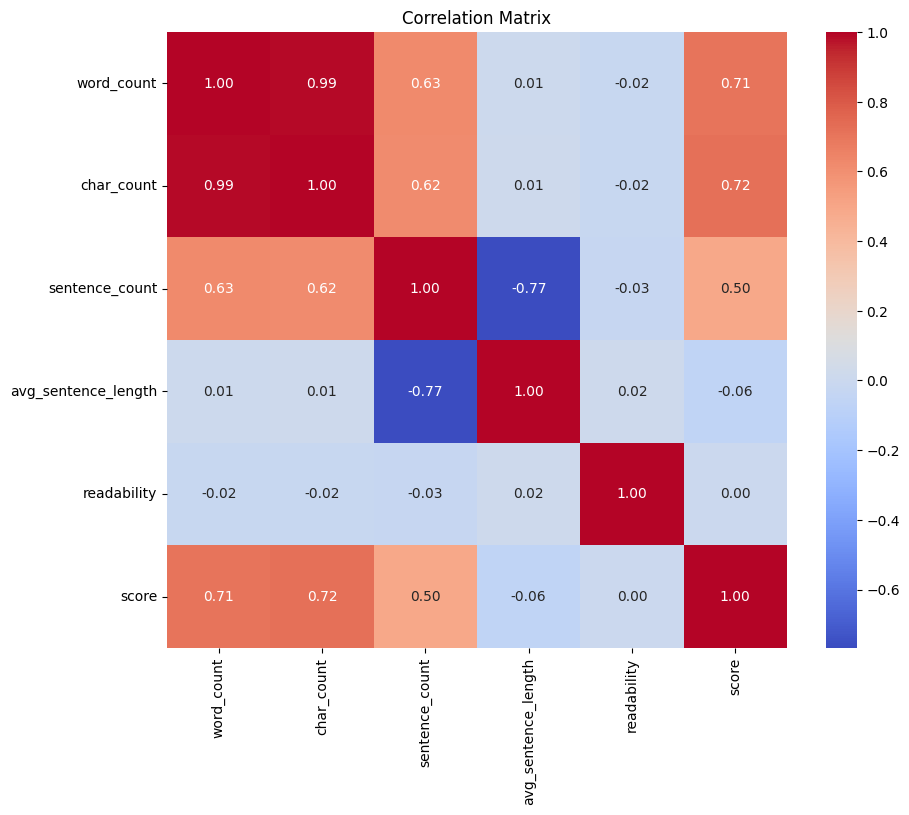

In [22]:
# Calculate the correlation matrix
correlation_matrix = df_train[['word_count', 'char_count', 'sentence_count', 'avg_sentence_length', 'readability', 'score']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [23]:
# export prepared training data
df_train.to_csv('training_data.csv')

In [24]:
# start H2O
h2o.init(max_mem_size='8G', nthreads=4) 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu220.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu220.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpn17zanpt
  JVM stdout: /tmp/tmpn17zanpt/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpn17zanpt/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 4 days
H2O_cluster_name:,H2O_from_python_unknownUser_iyv0jp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [25]:
# upload data in H2O environment
col4upload = ['essay_id'] + new_features # upload only necessary stuff
train_hex = h2o.H2OFrame(df_train[col4upload+['score']])
test_hex = h2o.H2OFrame(df_test[col4upload])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [26]:
# force categorical target
train_hex['score'] = train_hex['score'].asfactor()

# define predictors
predictors = new_features

In [27]:
# Define your random seed
my_random_seed = 42

# Define GLM model
glm_model = H2OGeneralizedLinearEstimator(
    family='multinomial',
    standardize=True,
    nfolds=5,
    alpha=0.5,  # 0:Ridge (L2 regularization), 1:LASSO (L1 regularization)
    score_each_iteration=True,
    seed=my_random_seed
)

# Assuming 'predictors' and 'train_hex' are defined and 'train_hex' is an H2OFrame
# predictors = ['col1', 'col2', ...]  # Example predictors
# train_hex = h2o.import_file("path_to_your_data.csv")  # Example of loading data


# Train the model
glm_model.train(predictors, 'score', training_frame=train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1713379724264_1


GLM Model: summary
    family       link         regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  -----------  -----------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    multinomial  multinomial  Elastic Net (alpha = 0.5, lambda = 4.581E-4 )  42                            31                             6                       py_1_sid_ac36

ModelMetricsMultinomialGLM: glm
** Reported on train data. **

MSE: 0.3649954640105704
RMSE: 0.6041485446565028
LogLoss: 1.0411990343607327
Null degrees of freedom: 17306
Residual degrees of freedom: 17270
Null deviance: 50284.042832703984
Residual deviance: 36040.06337536223
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2     3     4     5    6    Error     Rate
---  ----  ----  ----  ---  ---  --------  --------------
0    775   385   87    5    0    1         1,252 / 1,252
0    3157  1372  178   16   0    0.331569  1,566 / 4,723
0    1117  4258  859   43   3    0.321975  2,022 / 6,280
0    6     1614  2174  129  3    0.446256  1,752 / 3,926
0    0     22    671   274  3    0.717526  696 / 970
0    0     0     46    105  5    0.967949  151 / 156
0    5055  7651  4015  572  14   0.429826  7,439 / 17,307

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.570174
2    0.858843
3    0.959381
4    0.98908
5    0.997573
6    1

ModelMetricsMultinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.36566716108803404
RMSE: 0.6047041930465127
LogLoss: 1.042820449561198
Null degrees of freedom: 17306
Residual degrees of freedom: 17272
Null deviance: 50297.26475760495
Residual deviance: 36096.187041111305
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2     3     4     5    6    Error     Rate
---  ----  ----  ----  ---  ---  --------  --------------
0    776   385   86    5    0    1         1,252 / 1,252
0    3155  1373  180   15   0    0.331992  1,568 / 4,723
0    1110  4267  856   44   3    0.320541  2,013 / 6,280
0    5     1622  2170  126  3    0.447275  1,756 / 3,926
0    0     23    676   270  1    0.721649  700 / 970
0    0     0     45    108  3    0.980769  153 / 156
0    5046  7670  4013  568  10   0.429999  7,442 / 17,307

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.570001
2    0.85867
3    0.959381
4    0.989137
5    0.997573
6    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.569979  0.00901498  0.573913      0.562356      0.580663      0.558968      0.573992
aic                      nan       0           nan           nan           nan           nan           nan
auc                      nan       0           nan           nan           nan           nan           nan
err                      0.430021  0.00901498  0.426087      0.437644      0.419337     

In [28]:
# show cross validation results
glm_model.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.569979,0.009015,0.573913,0.562356,0.580663,0.558968,0.573992
1,aic,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
3,err,0.430021,0.009015,0.426087,0.437644,0.419337,0.441032,0.426008
4,err_count,1488.400000,33.110420,1470.000000,1523.000000,1479.000000,1522.000000,1448.000000
5,loglikelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,logloss,1.042849,0.011703,1.028928,1.041984,1.037718,1.060827,1.044790
7,max_per_class_error,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,mean_per_class_accuracy,0.366821,0.003016,0.364650,0.365259,0.371711,0.364716,0.367769
9,mean_per_class_error,0.633179,0.003016,0.635350,0.634741,0.628289,0.635284,0.632231


In [29]:
# show coefficients
glm_model.coef()

{'coefs_class_1': {'Intercept': -1.6661768802068972,
  'word_count': -0.36076190358411075,
  'char_count': -1.0596278140257227,
  'avg_word_length': -0.01741650906429059,
  'sentence_count': -0.17257899698884532,
  'avg_sentence_length': 0.09077021527108829,
  'readability': -1.756690528761871},
 'coefs_class_2': {'Intercept': 2.6146045413957983,
  'word_count': -0.694819130163519,
  'char_count': -0.7758254548843203,
  'avg_word_length': -0.6956230439557581,
  'sentence_count': -0.22723594166325511,
  'avg_sentence_length': -0.055469115220494504,
  'readability': -0.28376701528616033},
 'coefs_class_3': {'Intercept': 0.21223983929629736,
  'word_count': 0.0,
  'char_count': -0.0512644939909953,
  'avg_word_length': -0.09026397983763063,
  'sentence_count': -0.00886269390108557,
  'avg_sentence_length': 0.0,
  'readability': -0.28321746960322824},
 'coefs_class_4': {'Intercept': -5.969783239995737,
  'word_count': 0.6378871851350595,
  'char_count': 0.99312683313614,
  'avg_word_length

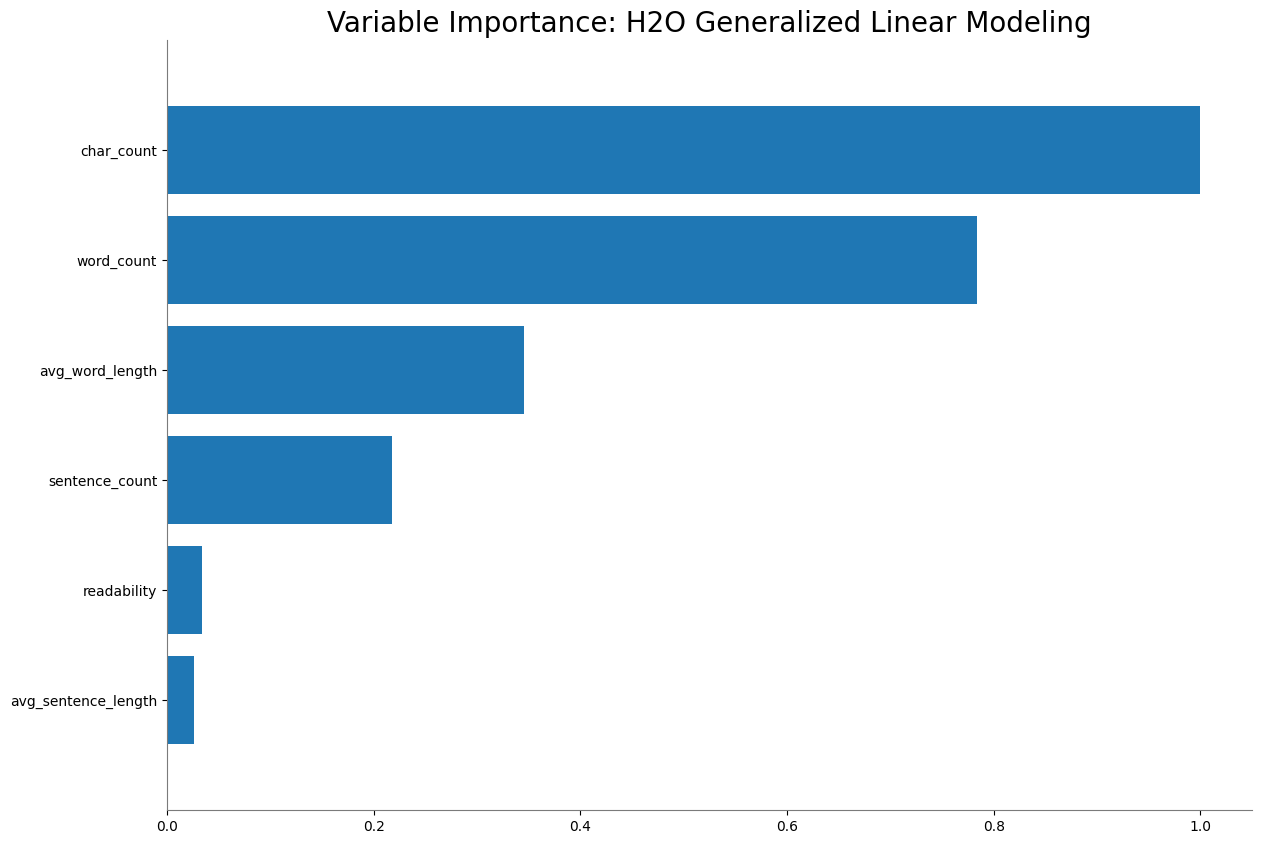

<Figure size 640x480 with 0 Axes>

In [30]:
# variable importance
glm_model.varimp_plot();

In [31]:
# predict on training data
pred_train = glm_model.predict(train_hex)
pred_train = pred_train.as_data_frame();
pred_train.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict,p1,p2,p3,p4,p5,p6
0,4,0.013763,0.048402,0.435658,0.462812,0.038157,0.001208
1,3,0.072941,0.350053,0.512943,0.063683,0.000379,0.000001
2,4,0.004390,0.012899,0.228276,0.607106,0.139240,0.008089
3,4,0.009878,0.026658,0.307603,0.544856,0.104199,0.006806
4,3,0.037678,0.115216,0.532632,0.298280,0.015722,0.000472


predict
2    5055
3    7651
4    4015
5     572
6      14
Name: count, dtype: int64


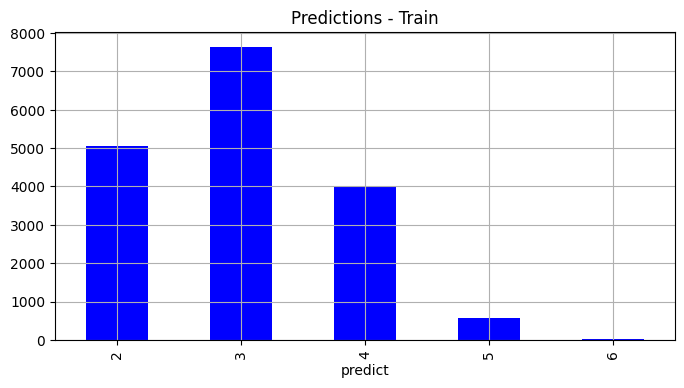

In [32]:
default_color_3 = 'blue'

# summary of predictions
print(pred_train.predict.value_counts().sort_index())
plt.figure(figsize=(8,4))
pred_train.predict.value_counts().sort_index().plot(kind='bar', color=default_color_3)
plt.title('Predictions - Train')
plt.grid()
plt.show()

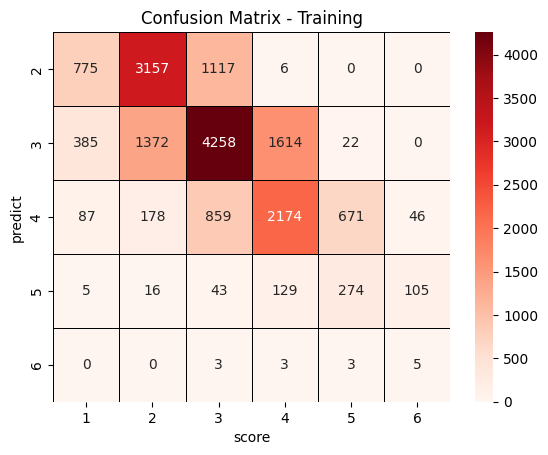

In [35]:
# confusion matrix
conf_train = pd.crosstab(pred_train.predict, df_train['score'])
sns.heatmap(conf_train, annot=True, cmap='Reds', 
            fmt='.0f', linecolor='black', linewidths=0.5)
plt.title('Confusion Matrix - Training')
plt.show()

In [36]:
# predict on test data
pred_test = glm_model.predict(test_hex)
pred_test = pred_test.as_data_frame();
pred_test.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict,p1,p2,p3,p4,p5,p6
0,3,0.042407,0.146949,0.579895,0.224641,0.005999,1.095960e-04
1,2,0.114498,0.721806,0.161224,0.002471,0.000001,9.821597e-10
2,4,0.007245,0.022382,0.297093,0.576380,0.093424,3.476751e-03


In [38]:
df_test

,essay_id,full_text,word_count,char_count,avg_word_length,sentence_count,avg_sentence_length,readability
0,000d118,Many people have car where they live. The thin...,0.458322,0.429949,5.383367,-0.873488,1.383304,0.542236
1,000fe60,I am a scientist at NASA that is discussing th...,-1.387805,-1.381747,5.015244,-0.526461,-0.946315,0.490972
2,001ab80,People always wish they had the same technolog...,0.929483,0.951798,5.568556,1.399949,-0.436989,0.459479


In [39]:
import pandas as pd

# Assuming you have an ID column in another DataFrame or Series called test_ids
df_sub = pd.DataFrame({
    'ID': df_test['essay_id']  # Replace 'test_ids' with the actual IDs from your test data
})

df_sub['score'] = pred_test['predict']

df_sub.to_csv('submission.csv', index=False)

df_sub = pd.read_csv('submission.csv')

In [40]:
df_sub

,ID,score
0,000d118,3
1,000fe60,2
2,001ab80,4


df_train